<a href="https://colab.research.google.com/github/sanjivch/MyML/blob/master/RNN_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising signals with PyTorch

Import libraries

In [0]:
import numpy as np
import math, random
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
def gen_signal(X, freq):
  return np.cos(2 * np.pi * X/ freq)
  

In [0]:
a = gen_signal(1, 60.0)

In [7]:
a

0.9945218953682733

In [0]:
def gen_signal_noise(X, _min, _max):
  return X + np.random.uniform(_min, _max, size=X.shape)

In [0]:
b = gen_signal_noise(np.array([0, 1 , 2]), 0.25, 0.5)

In [10]:
b

array([0.39039258, 1.36182208, 2.30617201])

In [0]:
def random_sample(_size):
  
  X = np.arange(_size)  
  out_target = gen_signal(X, 45.0)
  in_signal = gen_signal_noise(out_target, -0.5, 0.5)
  
  return in_signal, out_target

In [0]:
_in, _out = random_sample(20)

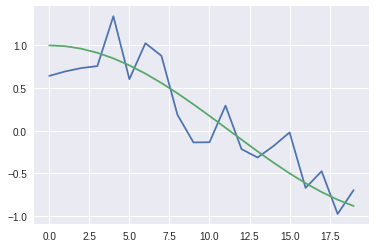

In [13]:
plt.plot(_in)
plt.plot(_out)

In [0]:
def gen_dataset(num_samples=10000,sample_size=100):
  # Create empty arrays - rows by columns
  data_in = np.zeros((num_samples, sample_size))
  data_out = np.zeros((num_samples, sample_size))
  
  for i in range(num_samples):
    _in, _out = random_sample(sample_size)
    
    # Create many samples with random noise
    data_in[i,:] = _in
    data_out[i,:] = _out
    
  return data_in, data_out

In [0]:
# Create a dataset
_input, _output = gen_dataset()


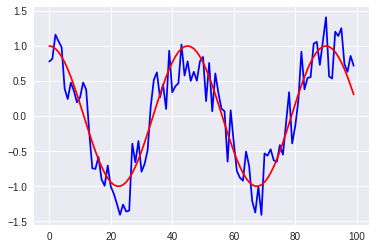

In [16]:
# Plot a sample
plt.plot(_input[0], 'b')
plt.plot(_output[0],'r')

In [0]:
# Split the dataset into train test set 70:30 ratio
train_input, train_output = _input[:7000],_output[:7000]
test_input, test_output = _input[7000:],_output[7000:]

In [18]:
import torch

ModuleNotFoundError: ignored

In [21]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
 

tcmalloc: large alloc 1073750016 bytes == 0x58542000 @  0x7fda753642a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable 

In [0]:
DIMENSION_IN = 1     # 1-D input
HIDDEN_SIZE = 40     # 40 hidden units
N_LAYERS = 1         # No. of layers in NN

In [0]:
class DenoiserRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(DenoiserRNN, self).__init__()
    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)
    self.activ = nn.Tanh()
    
  def forward(self, x):
    pred, hidden = self.rnn(x, None)
    pred = self.activ(self.linear(pred).view(pred.data.shape[0],-1,1))
    return pred
  
    

In [0]:
model = DenoiserRNN(DIMENSION_IN, HIDDEN_SIZE, N_LAYERS)

In [28]:
model

DenoiserRNN(
  (rnn): RNN(1, 40, batch_first=True)
  (linear): Linear(in_features=40, out_features=1, bias=True)
  (activ): Tanh()
)

In [37]:
# Training

from torch.optim import Adam

predictions = []

optimizer = Adam(model.parameters(), lr= 0.01)
loss_function = nn.L1Loss()

for i in range(401):
    hidden = None
    input = Variable(torch.Tensor(train_input.reshape((train_input.shape[0], -1, 1))), requires_grad=True)
    output = Variable(torch.Tensor(train_output.reshape((train_output.shape[0], -1, 1))) )
    pred = model(input)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_function(pred, output)
    
    # print the loss for every cycle
    if i%20==0:
        print(i, loss.data[0])
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0 tensor(0.0499)
20 tensor(0.9249)
40 tensor(0.9249)
60 tensor(0.9249)
80 tensor(0.9249)
100 tensor(0.9249)
120 tensor(0.9249)
140 tensor(0.9249)
160 tensor(0.9249)
180 tensor(0.9249)
200 tensor(0.9249)
220 tensor(0.9249)
240 tensor(0.9249)
260 tensor(0.9249)
280 tensor(0.9249)
300 tensor(0.9249)
320 tensor(0.9249)
340 tensor(0.9249)
360 tensor(0.9249)
380 tensor(0.9249)
400 tensor(0.9249)


In [0]:
t_input = Variable(torch.Tensor(test_input.reshape((test_input.shape[0], -1, 1))), requires_grad=True)
pred_t = model(t_input)

In [39]:
 # Test loss
print(loss_function(pred_t, Variable(torch.Tensor(test_output.reshape((test_input.shape[0], -1, 1))))).data[0])





tensor(0.9256)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Sample num: 85')

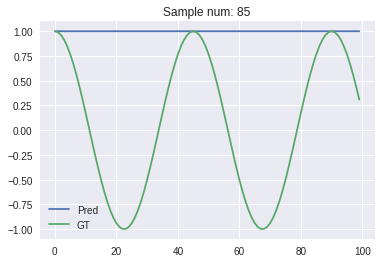

In [40]:
sample_num = 85
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_output[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))